# 版本说明v3 #
1. 使用了所有的feature
2. 使用了GradientBostingRegressor，因为XGBoost在使用pipeline的时候，无法对eval_set也是使用
3. 使用了归一化
4. 使用pipeline
5. 针对各个参数进行了调优

# 读取数据 #
训练集的大小是(4320,27)，因为前三列分别是”日期“，”测站“和”测项“，实际大小为(4320,24)。  
其中，4320又为(12,20,18)，分别对应”月份“，”日期“和”测项“。

In [68]:
import pandas as pd
import numpy as np

filepath_train = 'datas/train.csv' # 训练集的路径
filepath_test = 'datas/test.csv'   # 测试集的路径

data_train_orig = pd.read_csv(filepath_train,encoding='big5') # 读取训练集数据，台湾是用的big5码
data_test_orig = pd.read_csv(filepath_test,encoding='big5',
                          header=None,
                          index_col=0) # 读取测试集数据，没有列表，但是有index

index_pm25 = 9 # PM2.5的数据是在每日数据的第10行

data_train_orig = data_train_orig.iloc[:,3:] # 去掉前三列无用数据
data_train_orig[data_train_orig == 'NR'] = 0 # 设置雨量为NR的数据为0
data_train_orig = data_train_orig.to_numpy()

data_test_orig = data_test_orig.iloc[:,1:] # 去掉标识'测项'的第一列
data_test_orig[data_test_orig == 'NR'] = 0
data_test_numpy = data_test_orig.to_numpy()

# 转化每月数据 #
把数据(12\*20\*18,24)转化成(12,18,24\*18)的数据格式，对应(月份，测项，小时*每月天数)

In [69]:
data_train_month = np.empty([12,18,24*20])  # 定义初始值

for month in range(12):
    for day in range(20):
        row_start = (month * 20 + day) * 18 # 起始行，每月20天，每天18个特征
        row_end = row_start + 18            # 每天18个特征
        data_day = data_train_orig[row_start:row_end,:]        # 获得数据切片
        
        col_start = day * 24                # 每天有24小时
        col_end = col_start + 24
        data_train_month[month,:,col_start:col_end] = data_day # 设置数据切片

# 生成样本数据 #
因为是预测第十天的数据，所以连续九天的数据合并成一条数据,X_train_full的维度(12\*471,18\*9)

In [71]:
sample_number_month = 24 * 20 - 10 + 1                     # 计算每月的样本数

X_train_full = np.empty([sample_number_month * 12,18 * 9]) # 初始化训练集X
y_train_full = np.empty([sample_number_month * 12,])      # 初始化训练集y

for month in range(12):
    for sample in range(sample_number_month):
        col_start = sample           # 开始列
        col_end   = col_start + 9    # 取9列数据
        data_X = data_train_month[month,:,col_start:col_end].reshape(1,-1) # 变成一行数据
        data_y = data_train_month[month,index_pm25,col_end]                # y是下一列数据
        
        row = month * sample_number_month + sample # 插入数据的行号
        X_train_full[row,:] = data_X
        y_train_full[row] = data_y

test_number = data_test_numpy.shape[0] // 18
X_test = np.empty([test_number,18 * 9])
for sample in range(test_number):
    row_start = sample * 18
    row_end = row_start + 18
    X_test[sample] = data_test_numpy[row_start:row_end,:].reshape(1,-1)

# 拆分训练集和验证集 #

In [72]:
from sklearn.model_selection import train_test_split

X_train,X_valid,y_train,y_valid = train_test_split(X_train_full,
                                                   y_train_full,
                                                   test_size=0.2) # 分割验证集和验证集
n_features = X_train.shape[1]

# 使用pipeline #

In [107]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

model = GradientBoostingRegressor(random_state=0,
#                                   verbose=1,
                                  n_iter_no_change=5)

pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                           ('model' , model)])

pipeline.fit(X_train,y_train)

train_rmse = mean_squared_error(pipeline.predict(X_train),y_train)**0.5
valid_rmse = mean_squared_error(pipeline.predict(X_valid),y_valid)**0.5
print("训练集的RMSE:{:.5f}".format(train_rmse))
print("验证集的RMSE:{:.5f}".format(valid_rmse))
print("验证集的score:{:.5f}".format(pipeline.score(X_valid,y_valid)))

训练集的RMSE:5.47581
验证集的RMSE:6.33218
验证集的score:0.84931


# 定义超参搜索的工具 #

## 定义画学习曲线函数 ##

In [74]:
import matplotlib.pyplot as plt

def plot_validation_curve(train_scores,valid_scores,param_range,ylim=(0.7,1)):
    plt.plot(param_range,train_scores.mean(axis=1),label='train scores') # 画训练集的分数
    
    valid_mean = valid_scores.mean(axis=1)
    plt.plot(param_range,valid_mean,label='valid scores')                # 画验证集的分数

    valid_max = valid_mean.max()                           # 验证集中的最大分数
    valid_argmax = param_range[valid_mean.argmax()]        # 验证集最大分数对应的参数取值
    plt.plot(valid_argmax,valid_max,'x',)                  # 画出最大参数的位置
    plt.text(valid_argmax,valid_max + 0.01,
             '({},{:.4f})'.format(valid_argmax,valid_max)) # 画出最大参数的坐标值

    plt.legend()
    plt.ylim(ylim)
    plt.show()
    
    return valid_argmax,valid_max # 返回最大得分和对应的参数值

## 定义搜索函数 ##

In [97]:
from sklearn.model_selection import validation_curve

def search(param,param_range,ylim=(0.7,1)):
    train_scores,valid_scores = validation_curve(pipeline,
                                                 X_train,
                                                 y_train,
                                                 param,
                                                 param_range,
                                                 verbose=1,
                                                 n_jobs=4,
                                                 error_score=0)
    param_max,score_max = plot_validation_curve(train_scores,valid_scores,param_range)
    return (param_max,score_max,train_scores,valid_scores)

## 定义方格搜索函数 ##

In [76]:
from sklearn.model_selection import GridSearchCV

def grid_search(gridparam):
    grid_search = GridSearchCV(pipeline,gridparam,verbose=1,n_jobs=4)

    history = grid_search.fit(X_train,y_train)

    print(history.best_params_)
    print(history.best_score_)
    
    return history

# 超参搜索 #

In [32]:
from sklearn.model_selection import cross_val_score

cross_val_score(pipeline,X_train,y_train).mean() # 打印无调参时的score值

0.8550755926315773

## n_estimators参数调试 ##
**总结**
* 调整n_estimators后，score的提升只有0.0001
* 选择的值为115，score值为0.8552

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   32.7s finished


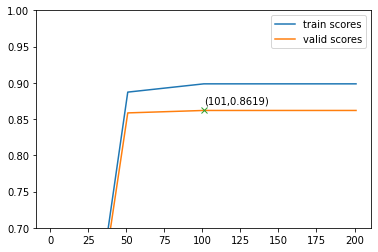

In [100]:
history = search('model__n_estimators',range(1,202,50))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  2.0min finished


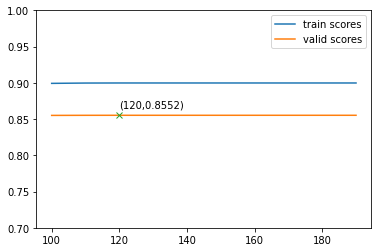

In [27]:
history = search('model__n_estimators',range(100,200,10))

In [41]:
history = grid_search({'model__n_estimators':range(115,125)})

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.0min finished


{'model__n_estimators': 115}
0.8552361113178757


## max_depth参数调试 ##
**总结**
1. max_depth越大，树越复杂，越容易overfitting，我现在面临的是overfitting，所以不需要试那么大的范围，从小开始就行了。
2. 最终发现4是最佳值，score为0.8565，提升0.013
3. 只是单个参数值时，validation_curve和grid_search的搜索结果一样，所以，用curve的效果更佳直观

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:  2.0min finished


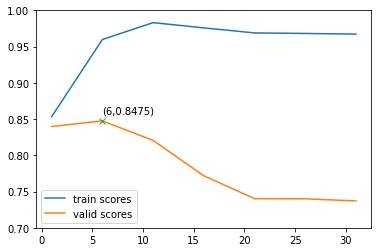

In [38]:
model.n_estimators = 115
history = search('model__max_depth',range(1,32,5))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  2.6min finished


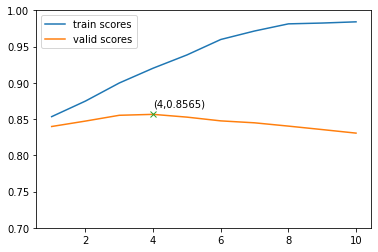

In [39]:
model.n_estimators = 115
history = search('model__max_depth',range(1,11))

In [44]:
model.n_estimators = 115
history = grid_search({'model__max_depth':range(1,11)})

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  2.9min finished


{'model__max_depth': 4}
0.8565162936905606


## 网格搜索n_estimators和max_depth两个参数 ##
**总结**
1. 搜索结果和把两个参数分开搜索的结果一致，可见两个参数不会互相影响
2. 还降了5课树，因为用了early stoping，所以差不多

In [48]:
params = {'model__n_estimators' : range(110,120),
          'model__max_depth' : range(3,6)}
history = grid_search(params)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  6.0min finished


{'model__max_depth': 4, 'model__n_estimators': 110}
0.8565162936905606


## min_samples_leaf参数调优 ##
**总结**  
1.variance是降了，但是bias提升了，导致实际数据还是1最好

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  2.3min finished


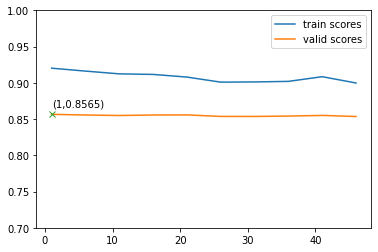

In [50]:
model.n_estimators = 110
model.max_depth = 4
history = search('model__min_samples_leaf',range(1,50,5))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.6min finished


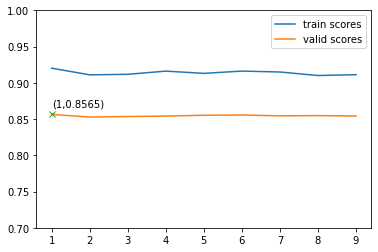

In [52]:
model.n_estimators = 110
model.max_depth = 4
history = search('model__min_samples_leaf',range(1,10))

## min_samples_split参数调优 ##
1. 没有调优空间

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:  1.5min finished


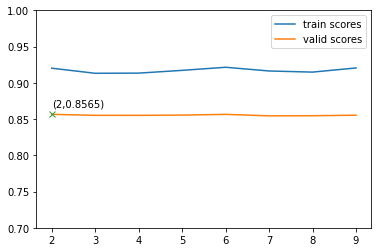

In [53]:
model.n_estimators = 110
model.max_depth = 4
history = search('model__min_samples_split',range(2,10))

## max_features参数调优 ##
**总结**
1. 有提升

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   56.9s finished


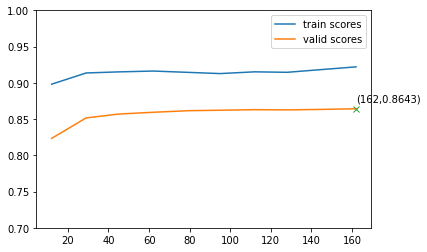

In [78]:
model.n_estimators = 110
model.max_depth = 4
param_range = np.linspace(n_features**0.5,n_features,10).astype(int)
history = search('model__max_features',param_range)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:  1.4min finished


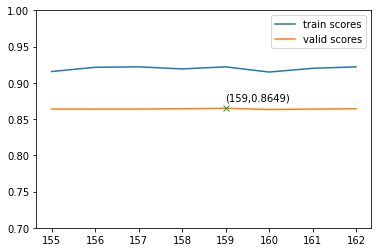

In [79]:
model.n_estimators = 110
model.max_depth = 4
history = search('model__max_features',range(155,163))

## 再调一下min_samples_leaf ##

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.8min finished


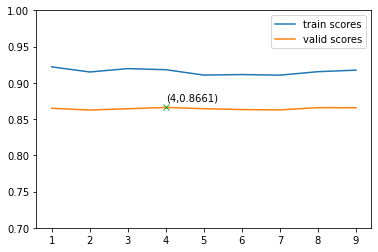

In [81]:
model.n_estimators = 110
model.max_depth = 4
model.max_features = 159
history = search('model__min_samples_leaf',range(1,10))

## 再调一下min_samples_split ##

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:  1.3min finished


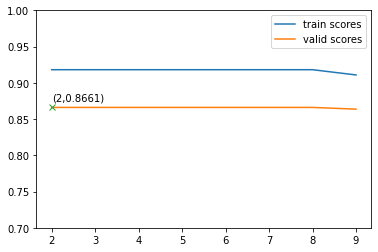

In [106]:
model.n_estimators = 110
model.max_depth = 4
model.max_features = 159
model.min_samples_leaf = 4
history = search('model__min_samples_split',range(2,10))

# 训练模型 #

In [108]:
from sklearn.metrics import mean_squared_error

model.n_estimators = 110
model.max_depth = 4
model.max_features = 159
model.min_samples_leaf = 4
model.min_samples_split = 2

pipeline.fit(X_train,y_train)

train_rmse = mean_squared_error(pipeline.predict(X_train),y_train)**0.5
valid_rmse = mean_squared_error(pipeline.predict(X_valid),y_valid)**0.5
print("训练集的RMSE:{:.5f}".format(train_rmse))
print("验证集的RMSE:{:.5f}".format(valid_rmse))
print("验证集的score:{:.5f}".format(pipeline.score(X_valid,y_valid)))

训练集的RMSE:4.78090
验证集的RMSE:6.24690
验证集的score:0.85334


# 输出数据 #

In [109]:
pipeline.fit(X_train_full,y_train_full)

preds_train_full = pipeline.predict(X_train_full)
print('训练集的RMSE:{:.5f}'.format(mean_squared_error(preds_train_full,y_train_full)**0.5))

preds_test = pipeline.predict(X_test)
ids = ['id_' + str(i) for i in range(len(X_test))]
output = pd.DataFrame({'id':ids,
                       'value':preds_test})
output.to_csv('output/submission.csv',index=False)

训练集的RMSE:4.83707
